# Phase 2 - EDA & Feature Engineering


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

DATASET_PATH = "./data/AirQualityUCI.csv"
OUTPUT_DIR = "./artifacts"
DATA_DIR = "./data"

In [34]:
# Create necessary directories if they don't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)

## 1. Load & Clean


In [35]:
# Load
raw = pd.read_csv(DATASET_PATH, sep=";", decimal=",")
# Drop fully empty columns
raw = raw.dropna(axis=1, how="all")

# Datetime
raw["datetime"] = pd.to_datetime(
    raw["Date"] + " " + raw["Time"], format="%d/%m/%Y %H.%M.%S", errors="coerce"
)
raw = raw.drop(columns=["Date", "Time"])

# Replace faulty values
FAULTY_VALUE = -200
num_cols = raw.select_dtypes(include=["number"]).columns
raw[num_cols] = raw[num_cols].replace(FAULTY_VALUE, np.nan)

# Sort & set index
raw = raw.sort_values("datetime").set_index("datetime")

print(raw.shape)
raw.head()

(9471, 13)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## 2. Time-based Train/Test Split


In [36]:
TEST_FRAC = 0.20

n = len(raw)
split_idx = int(n * (1 - TEST_FRAC))
train = raw.iloc[:split_idx].copy()
test = raw.iloc[split_idx:].copy()

train.to_csv(os.path.join(DATA_DIR, "train.csv"))
test.to_csv(os.path.join(DATA_DIR, "test.csv"))
print({"train_rows": len(train), "test_rows": len(test)})

{'train_rows': 7576, 'test_rows': 1895}


## 3. Data Quality Overview


In [37]:
dq = pd.DataFrame(
    {
        "missing_count": train.isna().sum(),
        "missing_pct": train.isna().mean().round(4) * 100,
        "min": train.min(numeric_only=True),
        "max": train.max(numeric_only=True),
        "mean": train.mean(numeric_only=True).round(3),
    }
).fillna("")
dq.head(n=15)

,missing_count,missing_pct,min,max,mean
CO(GT),1599,21.11,0.1000,11.900,2.209
PT08.S1(CO),280,3.70,647.0000,2040.000,1100.996
NMHC(GT),6662,87.94,7.0000,1189.000,218.812
C6H6(GT),280,3.70,0.2000,63.700,10.613
PT08.S2(NMHC),280,3.70,397.0000,2214.000,960.208
NOx(GT),1585,20.92,2.0000,1479.000,231.418
PT08.S3(NOx),280,3.70,322.0000,2683.000,848.097
NO2(GT),1588,20.96,2.0000,288.000,104.186
PT08.S4(NO2),280,3.70,682.0000,2775.000,1535.156
PT08.S5(O3),280,3.70,261.0000,2523.000,1024.376


## 4. Temporal Analysis (CO, NOx, Benzene)


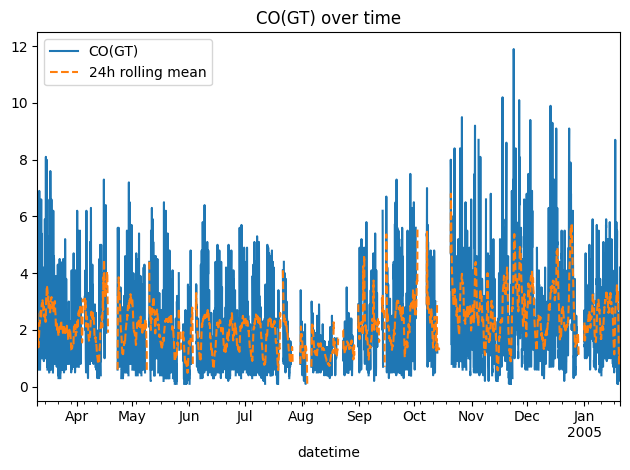

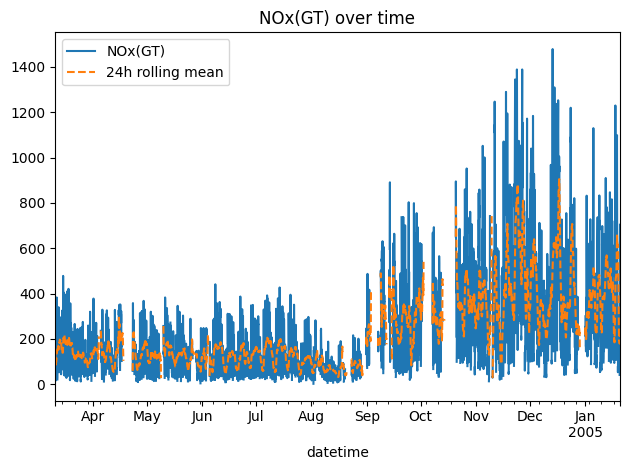

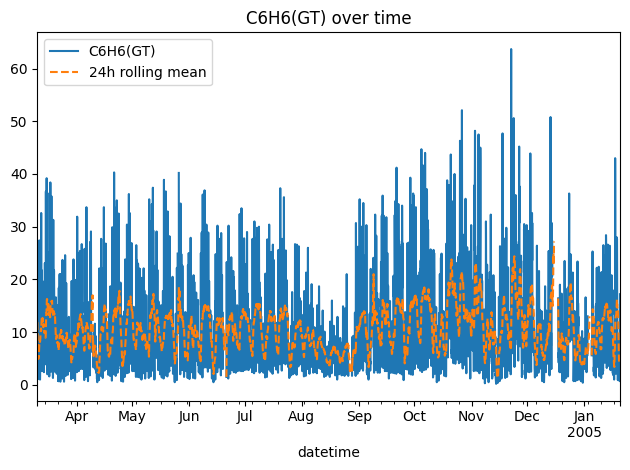

In [38]:
def plot_ts(df, col, outname):
    fig, ax = plt.subplots()
    df[col].plot(ax=ax, label=f"{col}")
    if df[col].notna().sum() > 48:
        df[col].rolling(24, min_periods=1).mean().plot(
            ax=ax, linestyle="--", label="24h rolling mean"
        )
    ax.set_title(f"{col} over time")
    ax.legend()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, outname))
    plt.show()


for col in ["CO(GT)", "NOx(GT)", "C6H6(GT)"]:
    if col in train.columns:
        plot_ts(train, col, outname=f"{col}_timeseries.png")

## 5. Operational Patterns


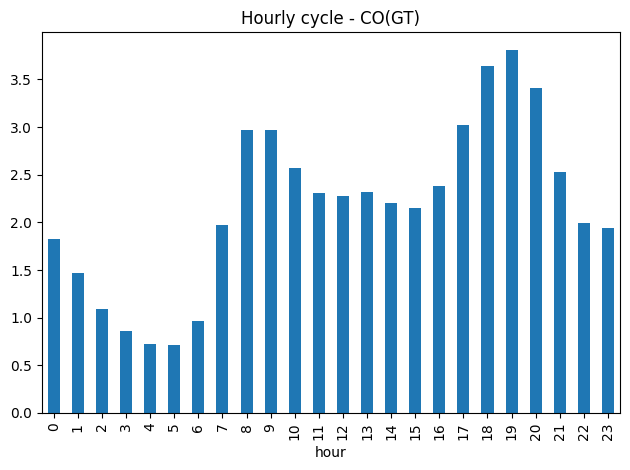

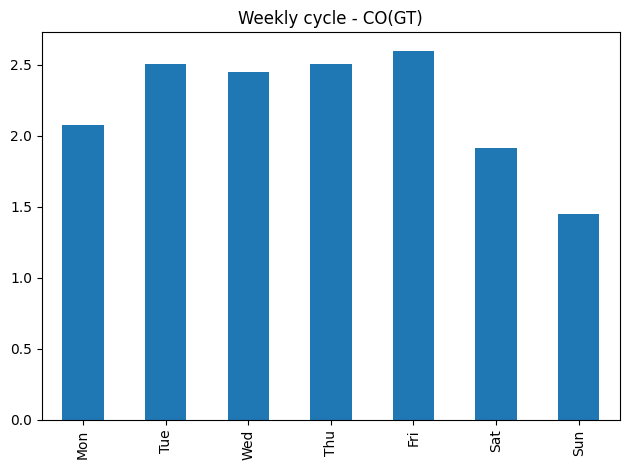

In [39]:
def hourly_weekly_profiles(df, col):
    tmp = df[[col]].dropna().copy()
    tmp["hour"] = tmp.index.hour
    tmp["dow"] = tmp.index.dayofweek  # 0=Mon..6=Sun
    hourly = tmp.groupby("hour")[col].mean()
    weekly = tmp.groupby("dow")[col].mean()
    return hourly, weekly


target = "CO(GT)"
if target in train.columns:
    h, w = hourly_weekly_profiles(train, target)

    # Hourly
    fig, ax = plt.subplots()
    h.plot(kind="bar", ax=ax)
    ax.set_title(f"Hourly cycle - {target}")
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{target}_hourly.png"))
    plt.show()

    # Weekly
    fig, ax = plt.subplots()
    w.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    w.plot(kind="bar", ax=ax)
    ax.set_title(f"Weekly cycle - {target}")
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, f"{target}_weekly.png"))
    plt.show()

## 6. Correlation Intelligence


In [40]:
corr_cols = [
    c for c in ["CO(GT)", "NOx(GT)", "C6H6(GT)", "T", "RH", "AH"] if c in train.columns
]
sub = train[corr_cols].dropna(how="any").astype(float)

corr = sub.corr()

# p-values table
pvals = pd.DataFrame(np.ones_like(corr), index=corr.index, columns=corr.columns)
for i, a in enumerate(corr_cols):
    for j, b in enumerate(corr_cols):
        if i < j:
            r, p = pearsonr(sub[a], sub[b])
            pvals.loc[a, b] = pvals.loc[b, a] = p

corr

,CO(GT),NOx(GT),C6H6(GT),T,RH,AH
CO(GT),1.000000,0.796114,0.937043,-0.065734,0.091665,-0.002143
NOx(GT),0.796114,1.000000,0.727078,-0.309311,0.289787,-0.119826
C6H6(GT),0.937043,0.727078,1.000000,0.103443,-0.012391,0.112133
T,-0.065734,-0.309311,0.103443,1.000000,-0.676325,0.569172
RH,0.091665,0.289787,-0.012391,-0.676325,1.000000,0.158960
AH,-0.002143,-0.119826,0.112133,0.569172,0.158960,1.000000


In [41]:
pvals

,CO(GT),NOx(GT),C6H6(GT),T,RH,AH
CO(GT),1.000000e+00,0.000000e+00,0.000000e+00,1.405132e-06,1.647676e-11,8.751451e-01
NOx(GT),0.000000e+00,1.000000e+00,0.000000e+00,1.480022e-119,1.575900e-104,1.182489e-18
C6H6(GT),0.000000e+00,0.000000e+00,1.000000e+00,2.872710e-14,3.636354e-01,1.629166e-16
T,1.405132e-06,1.480022e-119,2.872710e-14,1.000000e+00,0.000000e+00,0.000000e+00
RH,1.647676e-11,1.575900e-104,3.636354e-01,0.000000e+00,1.000000e+00,9.146050e-32
AH,8.751451e-01,1.182489e-18,1.629166e-16,0.000000e+00,9.146050e-32,1.000000e+00


## 7. Temporal Dependencies - ACF & PACF


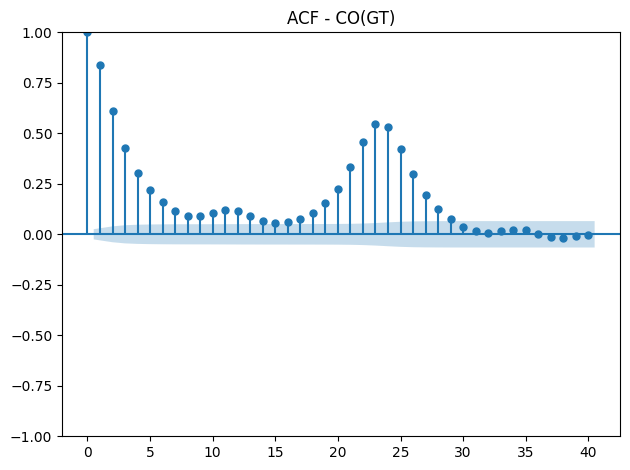

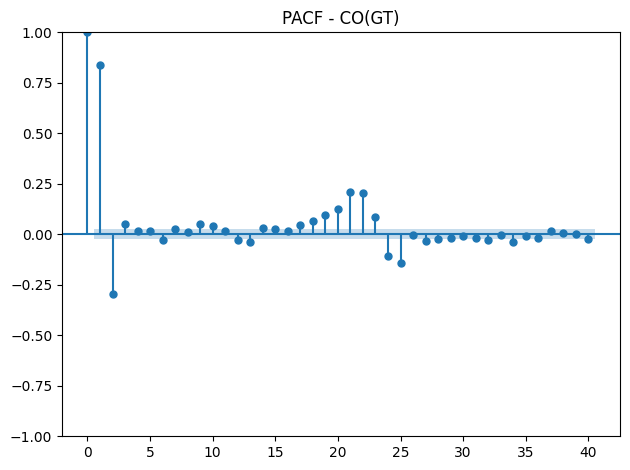

In [42]:
series = train["CO(GT)"].dropna().astype(float)

fig, ax = plt.subplots()
plot_acf(series, lags=40, ax=ax)
ax.set_title("ACF - CO(GT)")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "co_acf.png"))
plt.show()

fig, ax = plt.subplots()
plot_pacf(series, lags=40, ax=ax, method="yw_adjusted")
ax.set_title("PACF - CO(GT)")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "co_pacf.png"))
plt.show()

## 8. Seasonal Decomposition (CO)


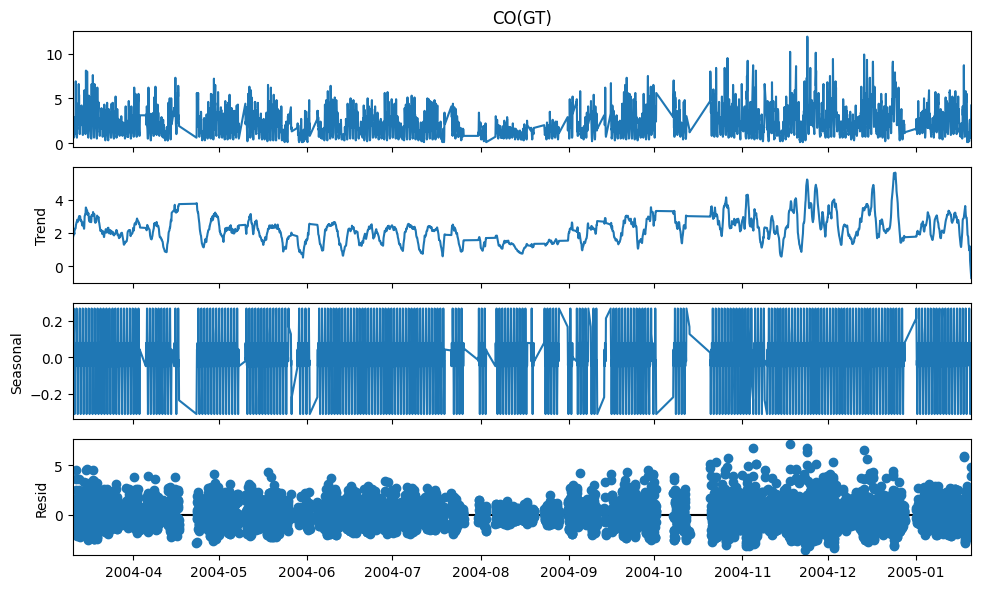

In [43]:
ser = train["CO(GT)"].astype(float).dropna()

result = seasonal_decompose(ser, model="additive", period=24, extrapolate_trend="freq")
fig = result.plot()
fig.set_size_inches(10, 6)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "co_decomposition.png"))
plt.show()

## 9. Feature Engineering


In [45]:
def make_features(df: pd.DataFrame, target="CO(GT)"):
    out = df.copy()
    out["hour"] = out.index.hour
    out["dow"] = out.index.dayofweek
    out["month"] = out.index.month

    # Lags
    for lag in [1, 2, 3, 6, 12, 24]:
        out[f"{target}_lag{lag}"] = out[target].shift(lag)

    # Rolling means
    for win in [3, 6, 24]:
        out[f"{target}_roll{win}"] = out[target].rolling(win, min_periods=1).mean()

    # Drop rows with NA created by lags/rolls
    out = out.dropna(
        subset=[target] + [f"{target}_lag{l}" for l in [1, 2, 3, 6, 12, 24]]
    )
    return out


feats = make_features(train, target="CO(GT)")
y = feats["CO(GT)"].astype(float)
X = feats.drop(columns=["CO(GT)"])

X.to_csv(os.path.join(DATA_DIR, "train_features.csv"))
y.to_csv(os.path.join(DATA_DIR, "train_target.csv"))
print(X.shape, y.shape)
X.head()

(4731, 24) (4731,)


,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,month,CO(GT)_lag1,CO(GT)_lag2,CO(GT)_lag3,CO(GT)_lag6,CO(GT)_lag12,CO(GT)_lag24,CO(GT)_roll3,CO(GT)_roll6,CO(GT)_roll24
datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-11 18:00:00,1581.0,307.0,20.8,1319.0,281.0,799.0,151.0,2083.0,1409.0,10.3,...,3,2.9,2.2,2.2,1.6,0.7,2.6,3.300000,2.816667,1.795652
2004-03-11 19:00:00,1776.0,461.0,27.4,1488.0,383.0,702.0,172.0,2333.0,1704.0,9.7,...,3,4.8,2.9,2.2,1.9,1.1,2.0,4.866667,3.650000,2.008696
2004-03-11 20:00:00,1640.0,401.0,24.0,1404.0,351.0,743.0,165.0,2191.0,1654.0,9.6,...,3,6.9,4.8,2.9,2.9,2.0,2.2,5.933333,4.183333,2.178261
2004-03-11 21:00:00,1313.0,197.0,12.8,1076.0,240.0,957.0,136.0,1707.0,1285.0,9.1,...,3,6.1,6.9,4.8,2.2,2.2,2.2,5.633333,4.466667,2.252174
2004-03-11 22:00:00,965.0,61.0,4.7,749.0,94.0,1325.0,85.0,1333.0,821.0,8.2,...,3,3.9,6.1,6.9,2.2,1.7,1.6,3.833333,4.350000,2.247826
